# Step 2: Looking at the Data Level 2


In this notebook we will analyze Crab DL2 collected with MAGIC+LST1 in several nights scattered over 2020 and 2021. We will build a counts map, check the achieved angular resolution, check the offset ($\theta$) of the reconstructed target position in relation to the real target position. We will start, however, by taking a closer look into the data itself.


### Let's start by loading some useful modules

In [5]:
import glob
import itertools
from pathlib import Path
import numpy as np
import pandas as pd
from pyirf.benchmarks import angular_resolution
from astropy import units as u
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from magicctapipe.io import get_dl2_mean, get_stereo_events
from magicctapipe.utils import calculate_off_coordinates
from matplotlib import pyplot as plt

In [6]:
# Display all the columns of a pandas data frame
pd.set_option("display.max_columns", None)

# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "dotted"}
)

# Get the pyplot default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load input DL2 data files

The data used here is available at the IT Container or at PIC.  

In this example we download the data to the directory /fefs/aswg/workspace/2023_joint_analysis_school /RFs_and_DL2/input/input_step_2/DL2-real/ 
Let's start by listing the input files with _glob_:

In [7]:
input_file_mask = '/fefs/aswg/workspace/2023_joint_analysis_school/RFs_and_DL2/input/input_step_2/DL2-real/*.h5' #e.g. my/path/to/the/data/*.h5

# Find the input files
input_files = glob.glob(input_file_mask)
input_files.sort()

Now let's read all of the data files and concatenate them in a single variable `event_data`:

In [8]:
print("The following files are found:")

data_list = []

for input_file in input_files:

    print(Path(input_file).name)

    # Load the input file
    df_events = pd.read_hdf(input_file, key="events/parameters")
    data_list.append(df_events)

event_data = pd.concat(data_list)
event_data.set_index(["obs_id", "event_id", "tel_id"], inplace=True)
event_data.sort_index(inplace=True)

The following files are found:
dl2_LST-1_MAGIC.Run02923.h5
dl2_LST-1_MAGIC.Run02924.h5
dl2_LST-1_MAGIC.Run03093.h5
dl2_LST-1_MAGIC.Run03265.h5
dl2_LST-1_MAGIC.Run03266.h5
dl2_LST-1_MAGIC.Run03267.h5
dl2_LST-1_MAGIC.Run03268.h5
dl2_LST-1_MAGIC.Run03631.h5
dl2_LST-1_MAGIC.Run03633.h5
dl2_LST-1_MAGIC.Run03634.h5
dl2_LST-1_MAGIC.Run03635.h5
dl2_LST-1_MAGIC.Run03636.h5
dl2_LST-1_MAGIC.Run04069.h5
dl2_LST-1_MAGIC.Run04070.h5
dl2_LST-1_MAGIC.Run04071.h5
dl2_LST-1_MAGIC.Run04125.h5


Now let's apply a quality cut to the data packed in the table "event_data" and take a look at it. We see that most of the stereo events (i.e. those detected with at least 2 telescopes) are detected by all three telescopes. Note that the "events" here are not just photons. They can be protons, electrons etc

In [9]:
quality_cuts = f"(disp_diff_mean < {np.sqrt(0.05)})"

# Apply the quality cuts
print(f"\nQuality cuts: {quality_cuts}")
event_data = get_stereo_events(event_data, quality_cuts)


Quality cuts: (disp_diff_mean < 0.22360679774997896)



In total 280403 stereo events are found:
    M1_M2 (type 0): 59977 events (21.4%)
    LST1_M1 (type 1): 22659 events (8.1%)
    LST1_M2 (type 2): 58633 events (20.9%)
    LST1_M1_M2 (type 3): 139134 events (49.6%) 


Now we exclude the MAGIC-stereo combination events, since they are poorly reconstructred with the current analysis scheme. This means that we are sacrificing the 59977 stereo MAGIC events that we just saw.

In [10]:
print("Excluding the MAGIC-stereo combination events...")
event_data.query("combo_type != 0", inplace=True)

Excluding the MAGIC-stereo combination events...


Let's take a look at the table "event_data", so we understand better how DL2 looks like:

In [11]:
# Show the data frame
event_data.head()

obs_id_magic  event_id_magic  obs_id_lst  \
obs_id event_id tel_id                                             
2923   2054693  1            5093174            2130      2923.0   
                2            5093174            2130      2923.0   
                3            5093174            2130      2923.0   
       2054766  1            5093174            2132      2923.0   
                2            5093174            2132      2923.0   

                        event_id_lst    intensity         x         y  \
obs_id event_id tel_id                                                  
2923   2054693  1          2054693.0   506.865746 -0.656543  0.090178   
                2          2054693.0   309.348958 -0.267904  0.084833   
                3          2054693.0   268.299479 -0.314013  0.010559   
       2054766  1          2054766.0  1539.117331  0.159153 -0.199730   
                2          2054766.0   682.101041  0.219247 -0.123636   

                               r         phi    length  length_uncertainty  \
obs_id event_id tel_id                                                       
2923   2054693  1       0.662707  172.179240  0.087614            0.005056   
                2       0.281014  162.429424  0.044108            0.001455   
                3       0.314191  178.074182  0.054217            0.002036   
       2054766  1       0.255385  -51.450648  0.095864            0.003028   
                2       0.251705  -29.419061  0.100258            0.002468   

                           width  width_uncertainty        psi  skewness  \
obs_id event_id tel_id                                                     
2923   2054693  1       0.038988           0.002505  48.813059 -0.369646   
                2       0.027682           0.001071  80.681458  0.067720   
                3       0.025034           0.000991  71.841862 -0.396296   
       2054766  1       0.041476           0.001832  39.938156 -0.450708   
                2       0.039357           0.001128  65.294646 -0.720628   

                        kurtosis     slope  intercept  intensity_width_1  \
obs_id event_id tel_id                                                     
2923   2054693  1       2.612286 -3.738599  19.435415                0.0   
                2       2.347090  4.956926  14.463646                0.0   
                3       2.513928 -2.827833  14.339549                0.0   
       2054766  1       2.467139 -7.488149  19.800128                0.0   
                2       2.653032  7.173953  15.740397                0.0   

                        intensity_width_2  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                      
2923   2054693  1                     0.0             0.0             0.0   
                2                     0.0             0.0             0.0   
                3                     0.0             0.0             0.0   
       2054766  1                     0.0             0.0             0.0   
                2                     0.0             0.0             0.0   

                        n_pixels  n_islands  pointing_alt  pointing_az  \
obs_id event_id tel_id                                                   
2923   2054693  1             27          1      0.784340     1.508031   
                2             27          1      0.784257     1.508029   
                3             26          1      0.784235     1.508001   
       2054766  1             42          1      0.784340     1.508031   
                2             61          1      0.784258     1.508029   

                           timestamp  time_diff  multiplicity  combo_type  \
obs_id event_id tel_id                                                      
2923   2054693  1       1.605743e+09   0.000023             3           3   
                2       1.605743e+09   0.002819             3           3   
                3       1.605743e+09   2.727715        

Each event listed above has parameters from 2 or 3 telescopes. In the step below we compute the means over these DL2 parameters such that each event will be assigned with average parameters for the involved telescopes.

In [12]:
print("Calculating mean DL2 parameters...")
event_data_mean = get_dl2_mean(event_data)

# Show the data frame
event_data_mean.head()

Calculating mean DL2 parameters...


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
2923   2054693            3             3  1.605743e+09      0.784277   
       2054766            3             3  1.605743e+09      0.784278   
       2055032            2             2  1.605743e+09      0.784289   
       2055078            3             3  1.605743e+09      0.784279   
       2056160            3             3  1.605743e+09      0.784285   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
2923   2054693      1.508020     0.299748  44.162489  87.500753   0.671238   
       2054766      1.508020     1.043020  45.782530  86.494834   0.444056   
       2055032      1.508017     0.408871  43.196749  86.753952   0.807917   
       2055078      1.508021     9.789184  44.389218  88.886664   0.001333   
       2056160      1.508024     0.552168  46.276207  86.950771   0.270024   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  
obs_id event_id                                                   
2923   2054693     83.966938     22.246320  84.472784  21.251777  
       2054766     83.966939     22.246320  83.077671  22.457811  
       2055032     83.966409     22.246677  85.644976  21.432480  
       2055078     83.966940     22.246323  83.878010  20.399164  
       2056160     83.966944     22.246331  82.462693  22.316038

Now we use the function `np.diff()` to take the difference between each value of timestamp and then sum up all of them to get the total exposure time.

In [13]:
time_diffs = np.diff(event_data_mean["timestamp"])
obs_time = time_diffs[time_diffs < 1].sum() * u.s

print(f"Observation time: {obs_time.to('min'):.1f}")

Observation time: 227.0 min


The timestamp is given in units of seconds. In the table shown above looks like all of the timestamps are the same, but if you look closely, they are slightly different:

In [14]:
print(event_data_mean["timestamp"].values[0])
print(event_data_mean["timestamp"].values[1])

1605742546.7277155
1605742546.7338173


### Calculate the angular distances from ON and OFF regions

In order to observe the target and the background at the same time, a common practice with IACTs is to misspoint the target by a wobble angle (typically 0.4$^{\circ}$ with MAGIC) such that the target and the background points lie in the same "ring" in the camera, as shown in the figure (Archambault et al. 2017):

![wobble](./figures/wobble_Archambault_2017.png)

The region named "ON" is where our target, in this case Crab, is. From now on, we will adopt 3 OFF regions that lie in the same camera ring. Let's set the ON-OFF coordinates of our target:

In [15]:
source_name = "Crab"
n_regions_off = 3

on_coord = SkyCoord.from_name(source_name, frame="icrs")

print(f"ON coordinate ({source_name}):")
print(on_coord)

#Let's also define a size to our sky map:
xlim = on_coord.ra.to_value("deg") + np.array([2, -2])
ylim = on_coord.dec.to_value("deg") + np.array([-2, 2])

print(f"\nNumber of OFF regions: {n_regions_off}")

ON coordinate (Crab):
<SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>

Number of OFF regions: 3


For each MAGIC-LST run we have a single observation ID and a single wobble. Below we do a loop over each run and plot the skymap for the ON-OFF points as well as the center of the camera. 


Observation ID: 2923

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.30315417, 22.4794202)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.71524766, 22.55590546)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.2195643, 21.93646319)>


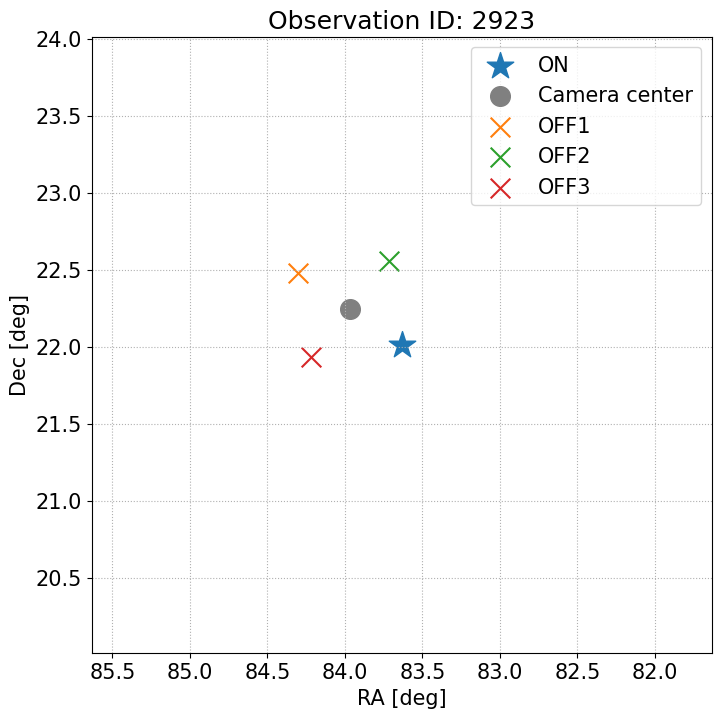


Observation ID: 2924

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.90000697, 21.56216585)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.50831226, 21.44683408)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.02330133, 22.12830673)>


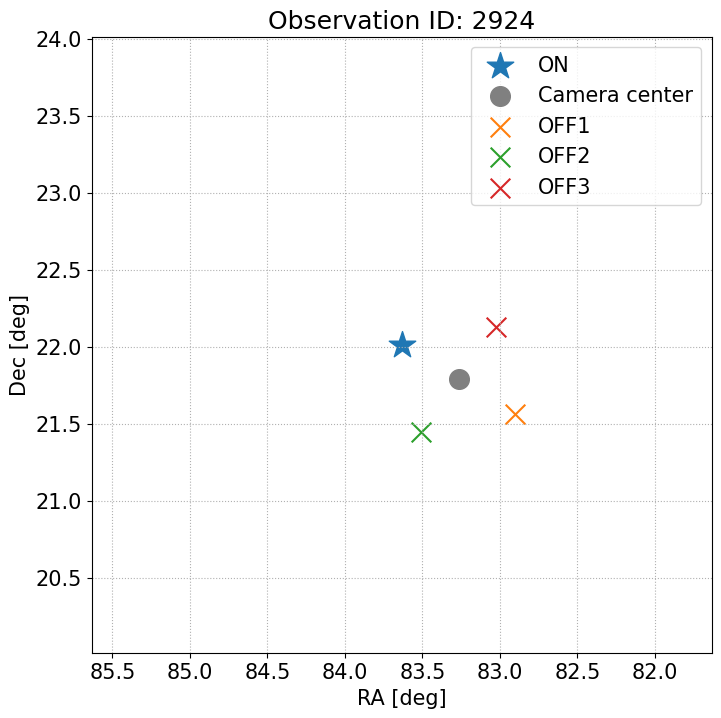


Observation ID: 3093

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.31465387, 22.47947219)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.72094194, 22.56124875)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.2253407, 21.9311719)>


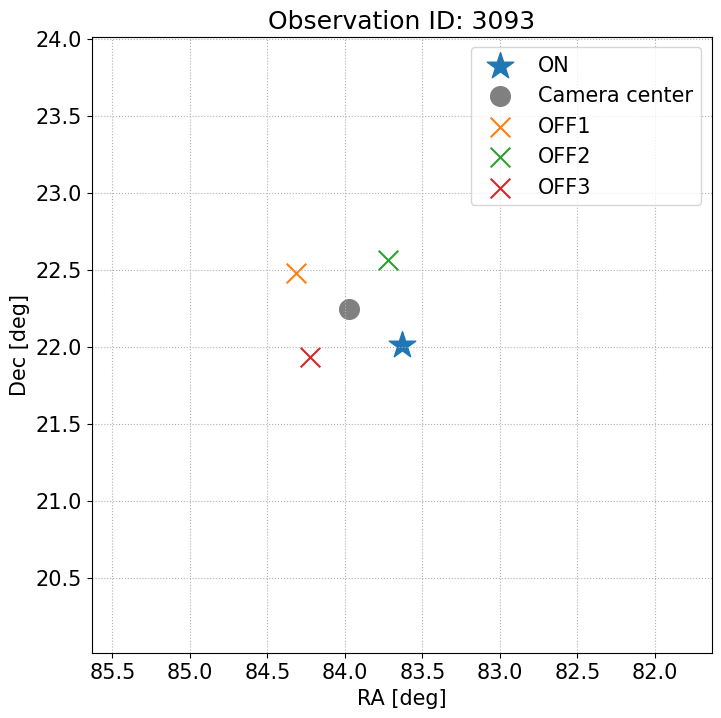


Observation ID: 3265

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.29858528, 22.48108892)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.71206802, 22.55462301)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.21818047, 21.93941154)>


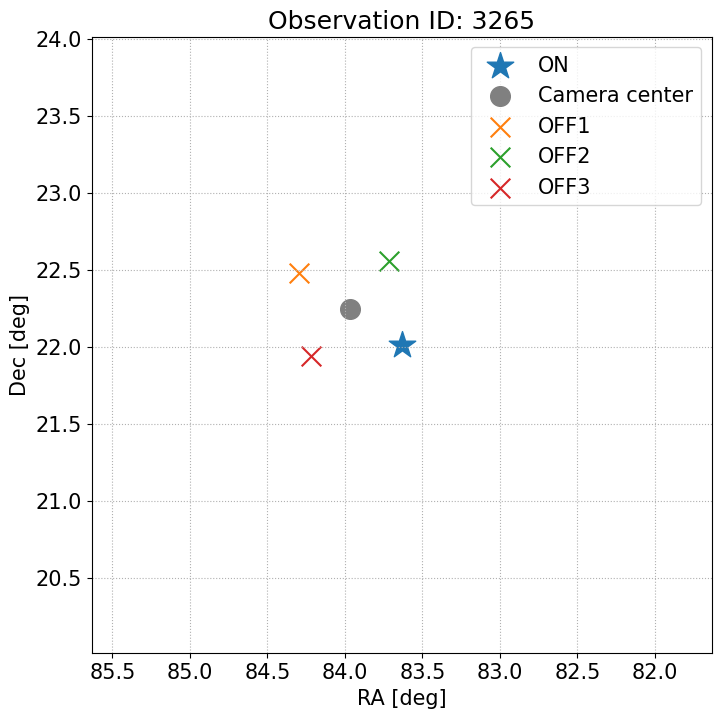


Observation ID: 3266

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.89383095, 21.56142193)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.50560822, 21.44359053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.01981201, 22.13080513)>


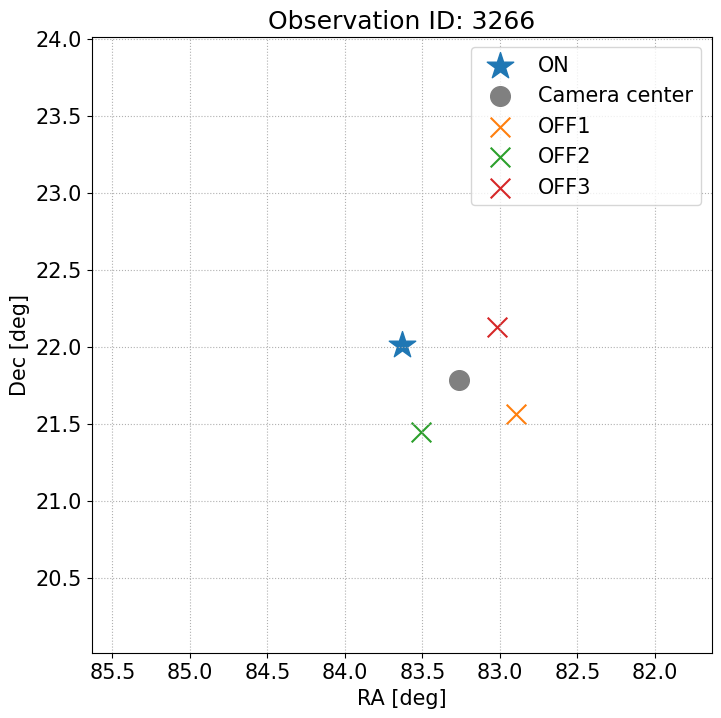


Observation ID: 3267

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.3045213, 22.47878887)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.71627076, 22.55622354)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.2199072, 21.93551485)>


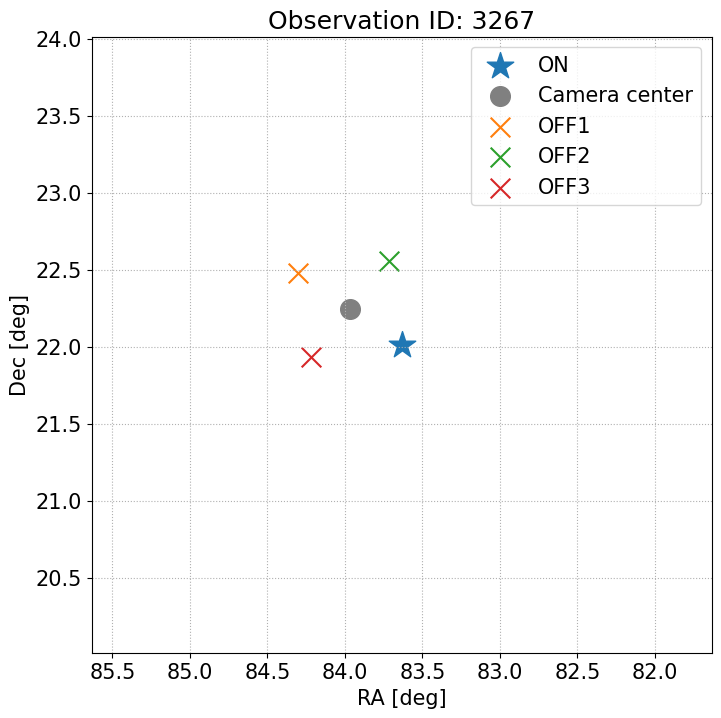


Observation ID: 3268

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.901135, 21.56361018)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.50810513, 21.44808407)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.02464459, 22.12850335)>


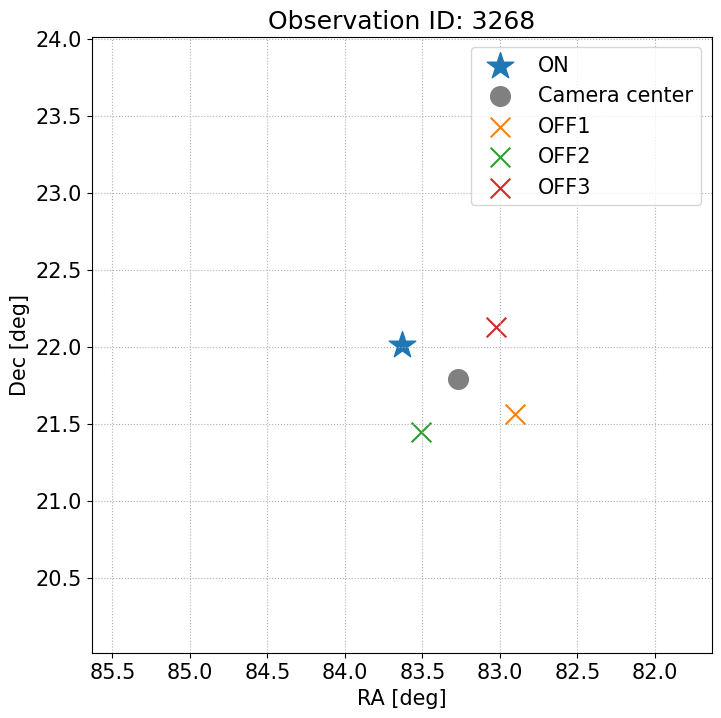


Observation ID: 3631

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.93382893, 21.55943856)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.52676327, 21.46117902)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.0387419, 22.11123051)>


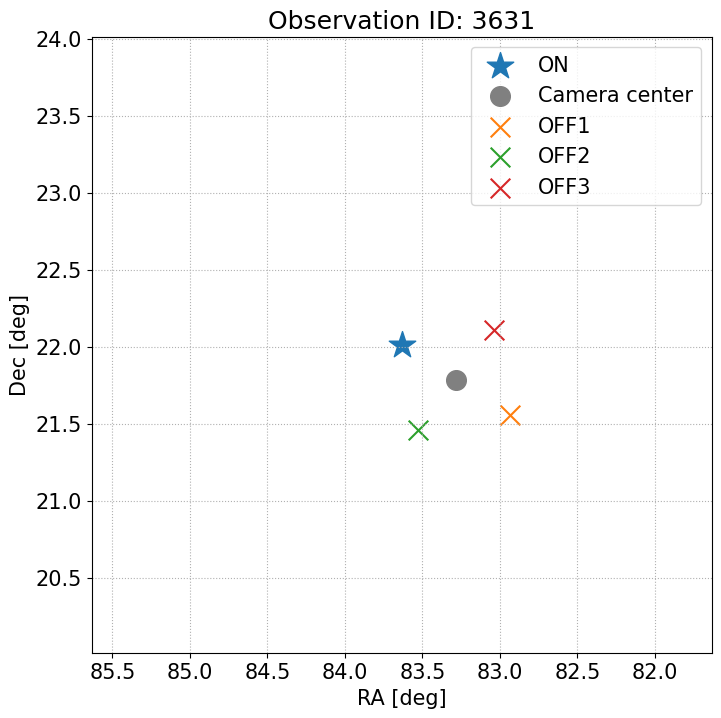


Observation ID: 3633

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.93785917, 21.55979751)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.52859534, 21.46323205)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.04095089, 22.10953702)>


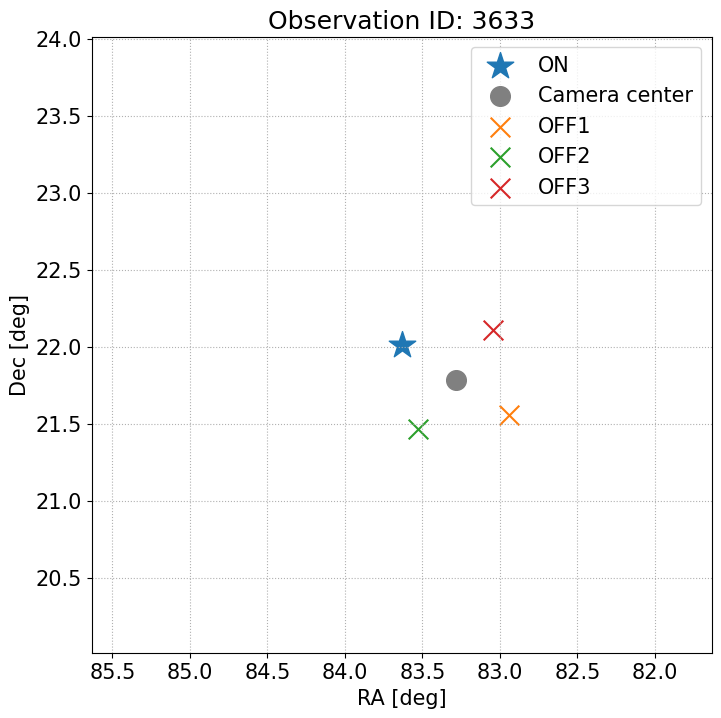


Observation ID: 3634

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.34729715, 22.47854205)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.73768988, 22.57588028)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.2411578, 21.91561206)>


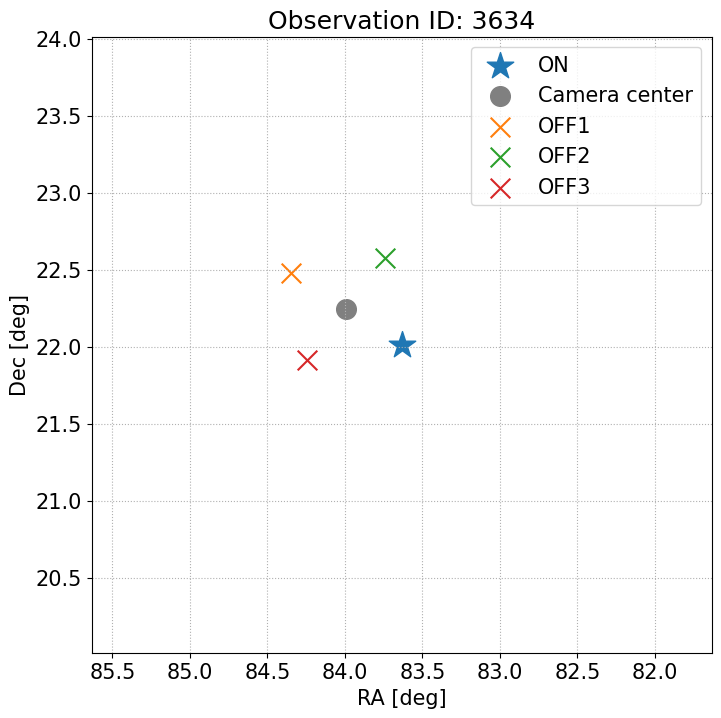


Observation ID: 3635

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.94168553, 21.55956386)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.5306425, 21.46489258)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.04273829, 22.1076425)>


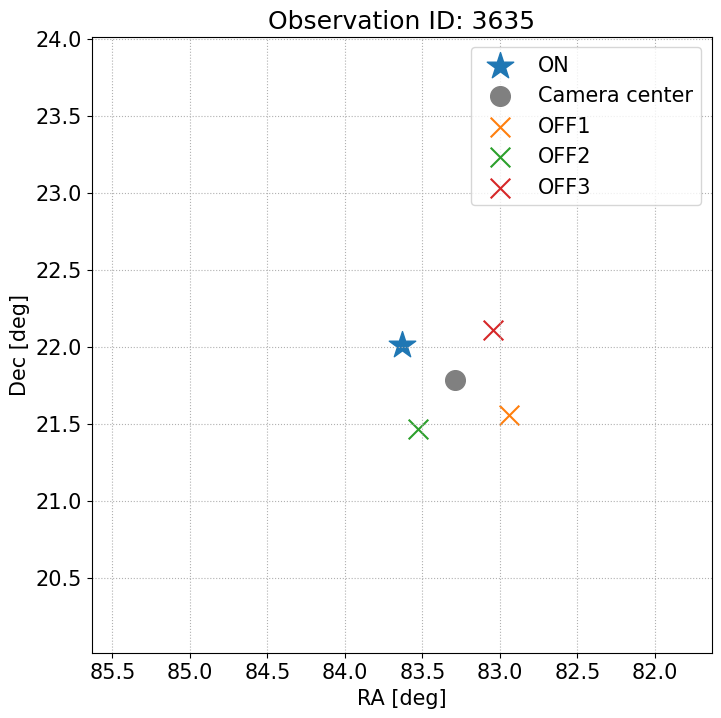


Observation ID: 3636

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.352936, 22.47746554)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.74108014, 22.57795226)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.24339648, 21.91246542)>


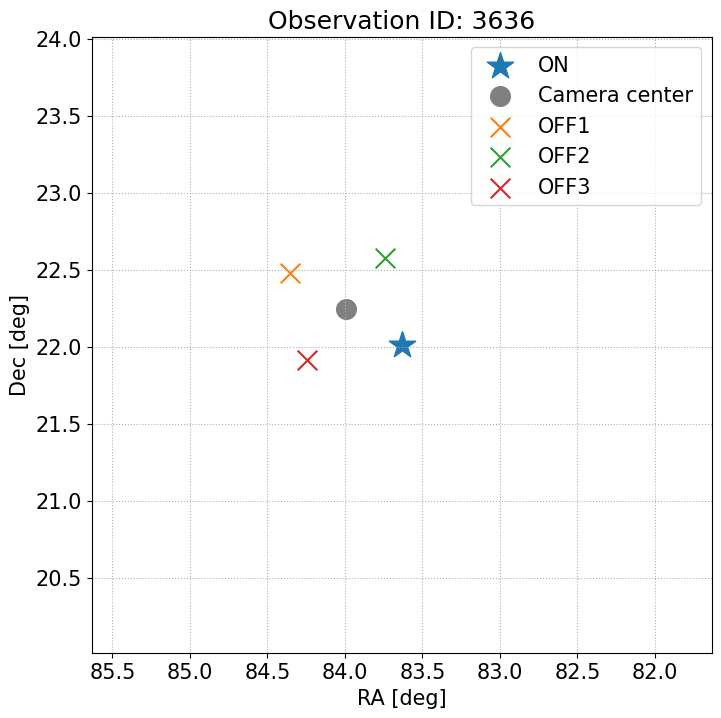


Observation ID: 4069

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.34803349, 22.48124062)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.73659075, 22.57756298)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.24298095, 21.91662344)>


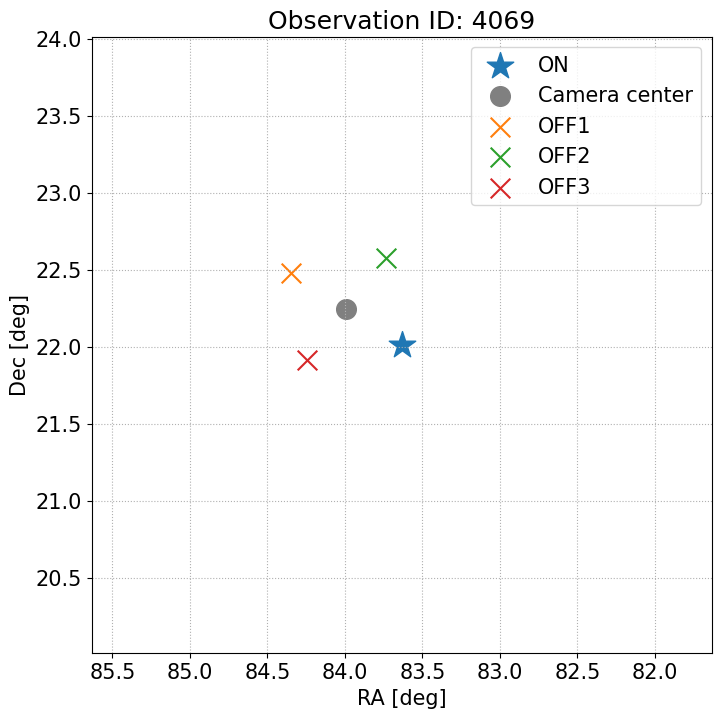


Observation ID: 4070

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.94159493, 21.56776772)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.52620093, 21.46897251)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.04711832, 22.11177929)>


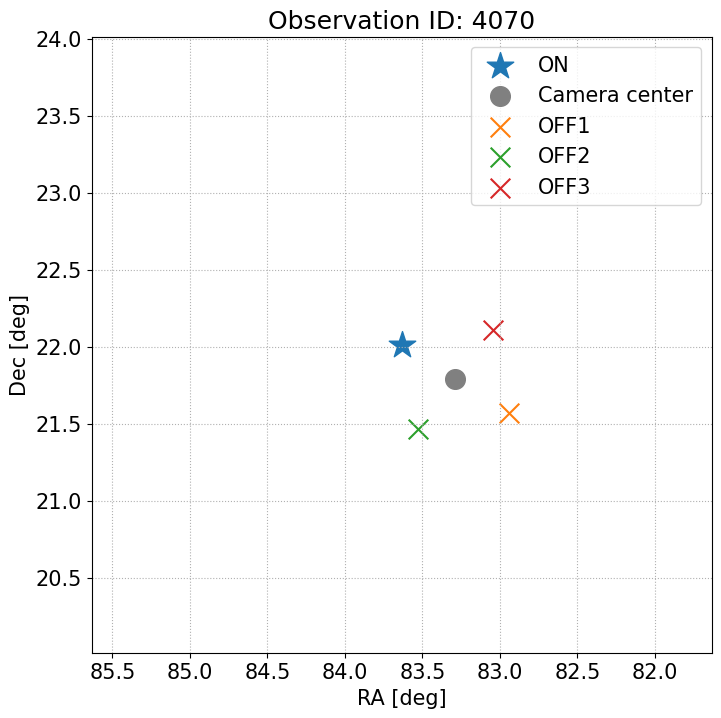


Observation ID: 4071

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.35213053, 22.48725722)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.73536163, 22.58244985)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.2482733, 21.91774308)>


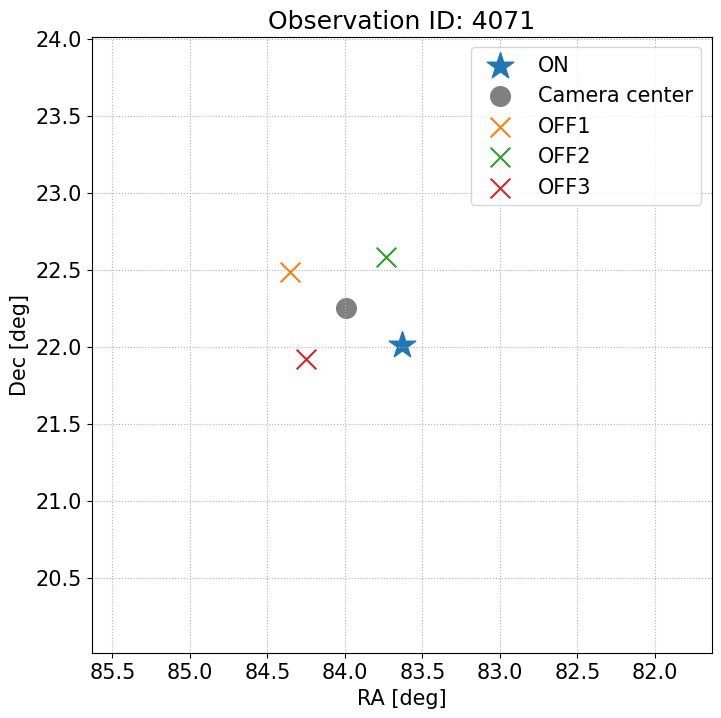


Observation ID: 4125

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.95092738, 21.57182012)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.52871663, 21.47534469)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.05397101, 22.10946584)>


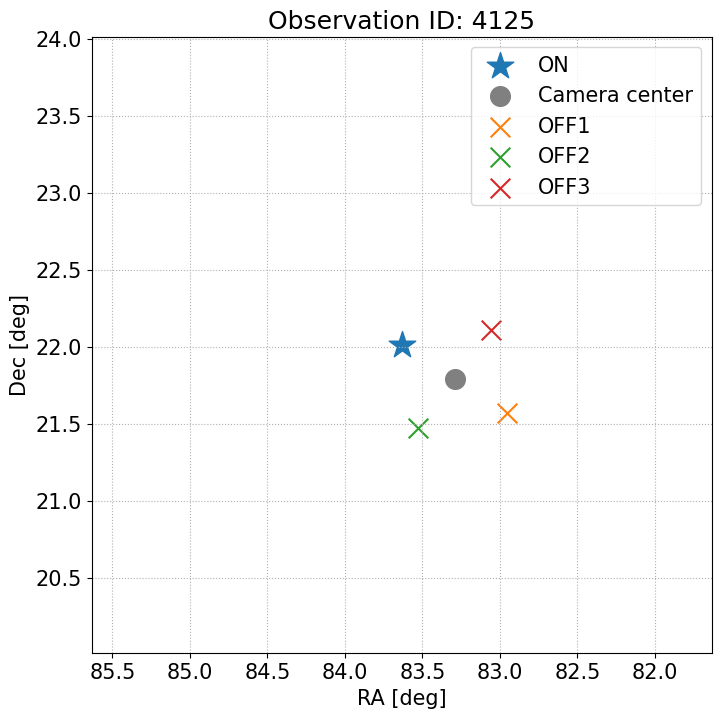

In [16]:
# Loop over every observation ID
obs_ids = np.unique(event_data_mean.index.get_level_values("obs_id"))

for obs_id in obs_ids:

    print(f"\nObservation ID: {obs_id}")
    df_events = event_data_mean.query(f"obs_id == {obs_id}")

    event_coords = SkyCoord(
        u.Quantity(df_events["reco_ra"], unit="deg"),
        u.Quantity(df_events["reco_dec"], unit="deg"),
        frame="icrs",
    )

    pnt_ra_mean = df_events["pointing_ra"].mean() * u.deg
    pnt_dec_mean = df_events["pointing_dec"].mean() * u.deg

    # Create a figure
    plt.figure(figsize=(8, 8))
    plt.title(f"Observation ID: {obs_id}")
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid()

    # Plot the ON coordinate
    plt.scatter(
        on_coord.ra.to("deg"), on_coord.dec.to("deg"), label="ON", marker="*", s=400
    )

    # Plot the pointing direction
    plt.scatter(
        pnt_ra_mean, pnt_dec_mean, label="Camera center", marker="o", s=200, color="grey"
    )

    # Calculate the angular distances from the ON region
    theta_on = on_coord.separation(event_coords)
    theta2_on = theta_on.to_value("deg") ** 2

    event_data_mean.loc[(obs_id, slice(None)), "theta2_on"] = theta2_on

    # Calculate the OFF coordinates
    off_coords = calculate_off_coordinates(
        pointing_ra=pnt_ra_mean,
        pointing_dec=pnt_dec_mean,
        on_coord_ra=on_coord.ra,
        on_coord_dec=on_coord.dec,
        n_regions=n_regions_off,
    )

    # Loop over every OFF coordinate
    print("\nOFF coordinates:")

    for i_off, off_coord in off_coords.items():

        print(off_coord)

        # Calculate the angular distance from the OFF coordinate
        theta_off = off_coord.separation(event_coords)
        theta2_off = theta_off.to_value("deg") ** 2

        event_data_mean.loc[(obs_id, slice(None)), f"theta2_off{i_off}"] = theta2_off

        # Plot the OFF coordinate
        plt.scatter(
            off_coord.ra.to("deg"),
            off_coord.dec.to("deg"),
            label=f"OFF{i_off}",
            marker="x",
            s=200,
            color=colors[i_off],
        )

    plt.legend()
    plt.show()

### Getting the list of photons

We now select only the events seen by all 3 telescopes and with a high probability (i.e. _gammaness_) of being gamma rays.

In [17]:
# Only events observed with all 3 telescopes:
combo_types = [3] # You can play with different combinations, e.g. with [2,3], or [2] 
# Only events observed with high prob of being gamma rays:
cut_value_gh = 0.8

print(f"Combination types: {combo_types}")
print(f"Global gammaness cut: {cut_value_gh}")

# Get the photon list
event_list = event_data_mean.query(
    f"(combo_type == {combo_types}) & (gammaness > {cut_value_gh})"
).copy()

print(f"\nNumber of events: {len(event_list)}")

# Show the event list
event_list.head()

Combination types: [3]
Global gammaness cut: 0.8

Number of events: 32674


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
2923   2062474            3             3  1.605743e+09      0.784321   
       2063703            3             3  1.605743e+09      0.784328   
       2075116            3             3  1.605743e+09      0.784392   
       2079064            3             3  1.605743e+09      0.784412   
       2079662            3             3  1.605743e+09      0.784416   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
2923   2062474      1.508040     0.200270  45.739499  86.628774   0.953667   
       2063703      1.508043     0.284152  46.316528  86.103113   0.978889   
       2075116      1.508072     0.274301  43.788132  86.671243   0.871032   
       2079064      1.508082     0.235720  45.266120  87.560046   0.933405   
       2079662      1.508083     0.210022  45.224877  86.301202   0.824317   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  theta2_on  \
obs_id event_id                                                               
2923   2062474     83.966968     22.246383  83.092230  22.355508   0.368130   
       2063703     83.966973     22.246394  82.624886  22.884393   1.627393   
       2075116     83.966999     22.246464  85.075112  21.687787   1.896734   
       2079064     83.967002     22.246481  83.350069  21.583768   0.253700   
       2079662     83.967002     22.246484  83.705275  22.407764   0.160011   

                 theta2_off1  theta2_off2  theta2_off3  
obs_id event_id                                         
2923   2062474      1.268435     0.371677     1.265870  
       2063703      2.561725     1.119433     3.071868  
       2075116      1.138359     2.340564     0.692744  
       2079064      1.582718     1.059576     0.776508  
       2079662      0.310494     0.022031     0.448946

### Check the count map

Let's quickly do a counts map to see what we have.

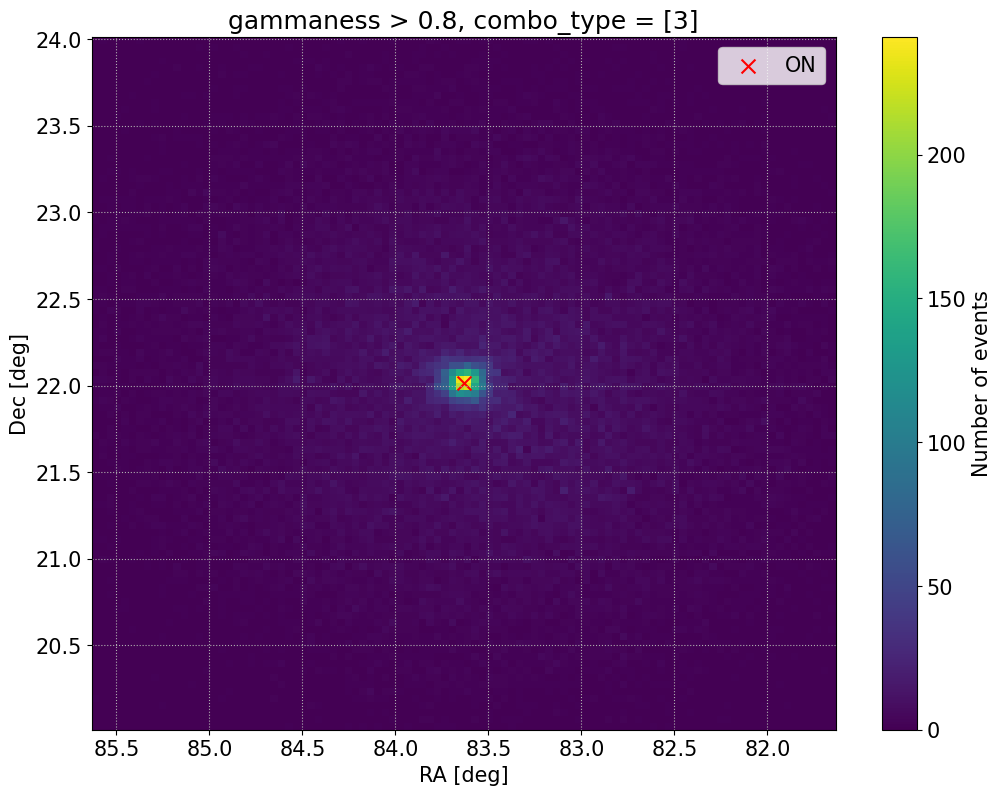

In [18]:
plt.figure()
plt.title(f"gammaness > {cut_value_gh}, combo_type = {combo_types}")
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.xlim(xlim)
plt.ylim(ylim)

# Plot the count map
plt.hist2d(
    event_list["reco_ra"],
    event_list["reco_dec"],
    bins=[np.linspace(xlim[1], xlim[0], 101), np.linspace(ylim[0], ylim[1], 101)],
)

plt.colorbar(label="Number of events")
plt.axis(xlim.tolist() + ylim.tolist())
plt.grid()

# Plot the ON coordinate
plt.scatter(
    on_coord.ra.to("deg"),
    on_coord.dec.to("deg"),
    marker="x",
    s=100,
    color="red",
    label="ON",
)

plt.legend()

### Check the $\theta^2$ distributions

$\theta$ is defined as the offset angle between the real position of the target and the reconstructed position for a single event, as shown in the figure below:

![theta](./figures/theta.png)

The $\theta^2$ distribution gives us a sort of point spread function for the IACT.

So let's start by setting up a range at which we want to look for events, let's say from 0 to 0.9$^{\circ}$, and let's also define a cutting value at $\theta = 0.2^{\circ}$ (or $\theta^2 = 0.04^{\circ}$):

In [19]:
theta2_bins = np.linspace(0, 0.9, 81)  # unit: [deg2]
cut_value_theta2 = 0.04  # unit: [deg2]

theta2_bins_center = (theta2_bins[:-1] + theta2_bins[1:]) / 2

theta2_bins_width = [
    theta2_bins_center - theta2_bins[:-1],
    theta2_bins[1:] - theta2_bins_center,
]

Now let's plot this distribution and compute the significance of the Crab signal.
Since the distribution of photons is not Poissonian, the proper way to go is using the Li & Ma significance (https://arxiv.org/abs/astro-ph/0411660).

Global theta2 cut: 0.04 [deg2]

Non: 5075

Noff1: 971
Noff2: 1039
Noff3: 1020
--> Total Noff: 3030

alpha = 0.333
--> Scaled Noff: 1010

Nexcess: 4065
Observation time: 227.0 min
--> Excess rate: 17.9 [1/min]

Li&Ma significance: 71.4 sigma


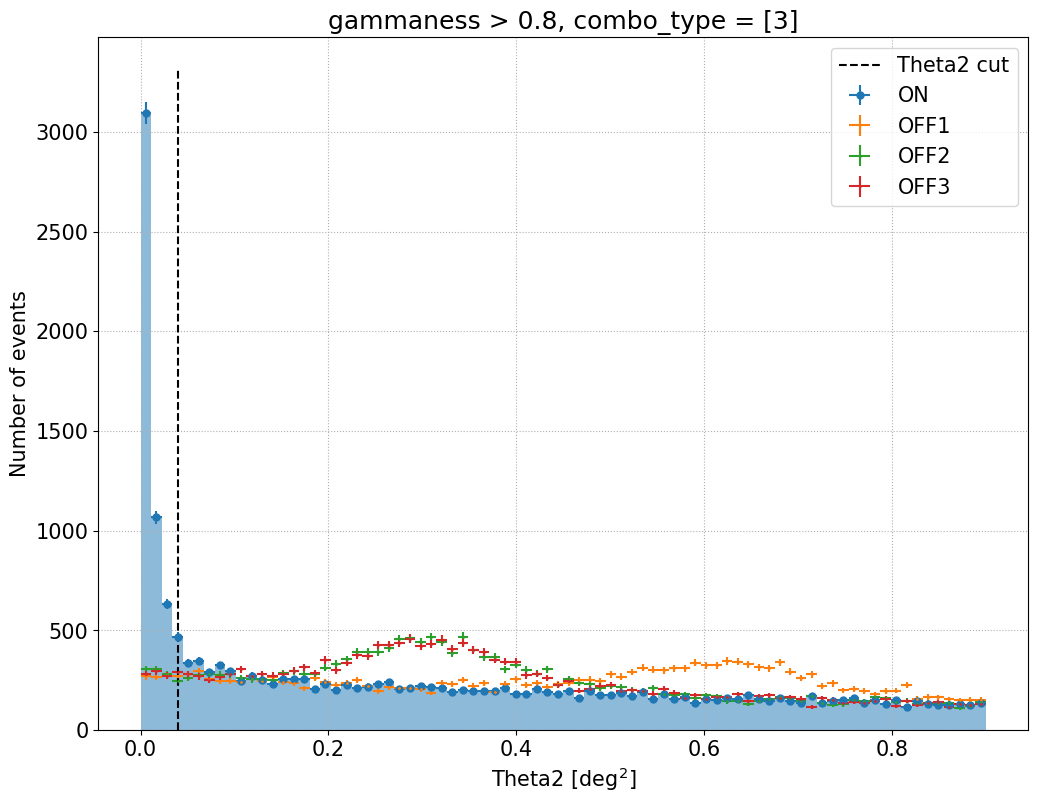

In [20]:
plt.figure()
plt.title(f"gammaness > {cut_value_gh}, combo_type = {combo_types}")
plt.xlabel("Theta2 [deg$^2$]")
plt.ylabel("Number of events")
plt.grid()

# Plot the theta2 distribution from the ON coordinate
hist_on = plt.hist(
    event_list["theta2_on"], bins=theta2_bins, histtype="bar", linewidth=2, alpha=0.5
)[0]

plt.errorbar(
    x=theta2_bins_center,
    y=hist_on,
    xerr=theta2_bins_width,
    yerr=np.sqrt(hist_on),
    fmt="o",
    markersize=5,
    label="ON",
    color=colors[0],
)

# Plot the theta2 distrubutions from the OFF coordinates
for i_off in range(n_regions_off):

    hist_off, _ = np.histogram(event_list[f"theta2_off{i_off+1}"], bins=theta2_bins)

    plt.errorbar(
        x=theta2_bins_center,
        y=hist_off,
        xerr=theta2_bins_width,
        yerr=np.sqrt(hist_off),
        fmt="o",
        markersize=1,
        label=f"OFF{i_off+1}",
    )

# Plot the theta2 cut
print(f"Global theta2 cut: {cut_value_theta2} [deg2]")

plt.plot(
    np.repeat(cut_value_theta2, 2),
    (0, plt.ylim()[1]),
    linestyle="--",
    color="black",
    label=f"Theta2 cut",
)

plt.legend(loc="upper right")

# Calculate the numbers ON, OFF and excess events
n_on = len(event_list.query(f"theta2_on < {cut_value_theta2}"))
print(f"\nNon: {n_on}\n")

n_off_total = 0

for i_off in range(n_regions_off):

    n_off = len(event_list.query(f"theta2_off{i_off+1} < {cut_value_theta2}"))
    print(f"Noff{i_off+1}: {n_off}")

    n_off_total += n_off

print(f"--> Total Noff: {n_off_total}")

alpha = 1 / n_regions_off
n_off_scaled = n_off_total * alpha

print(f"\nalpha = {alpha:.3f}")
print(f"--> Scaled Noff: {n_off_scaled:.0f}")

n_excess = n_on - n_off_scaled
excess_rate = n_excess / obs_time.to_value("min")

print(f"\nNexcess: {n_excess:.0f}")
print(f"Observation time: {obs_time.to('min'):.1f}")
print(f"--> Excess rate: {excess_rate:.1f} [1/min]")

# Calculate the Li&Ma significance
stat = WStatCountsStatistic(n_on, n_off_total, alpha=alpha)
significance = stat.sqrt_ts

print(f"\nLi&Ma significance: {significance:.1f} sigma")

We now repeat the process, but this time slicing the data in different energy bins. We see that the distribution of events gets tighter and the background drops for higher energies.

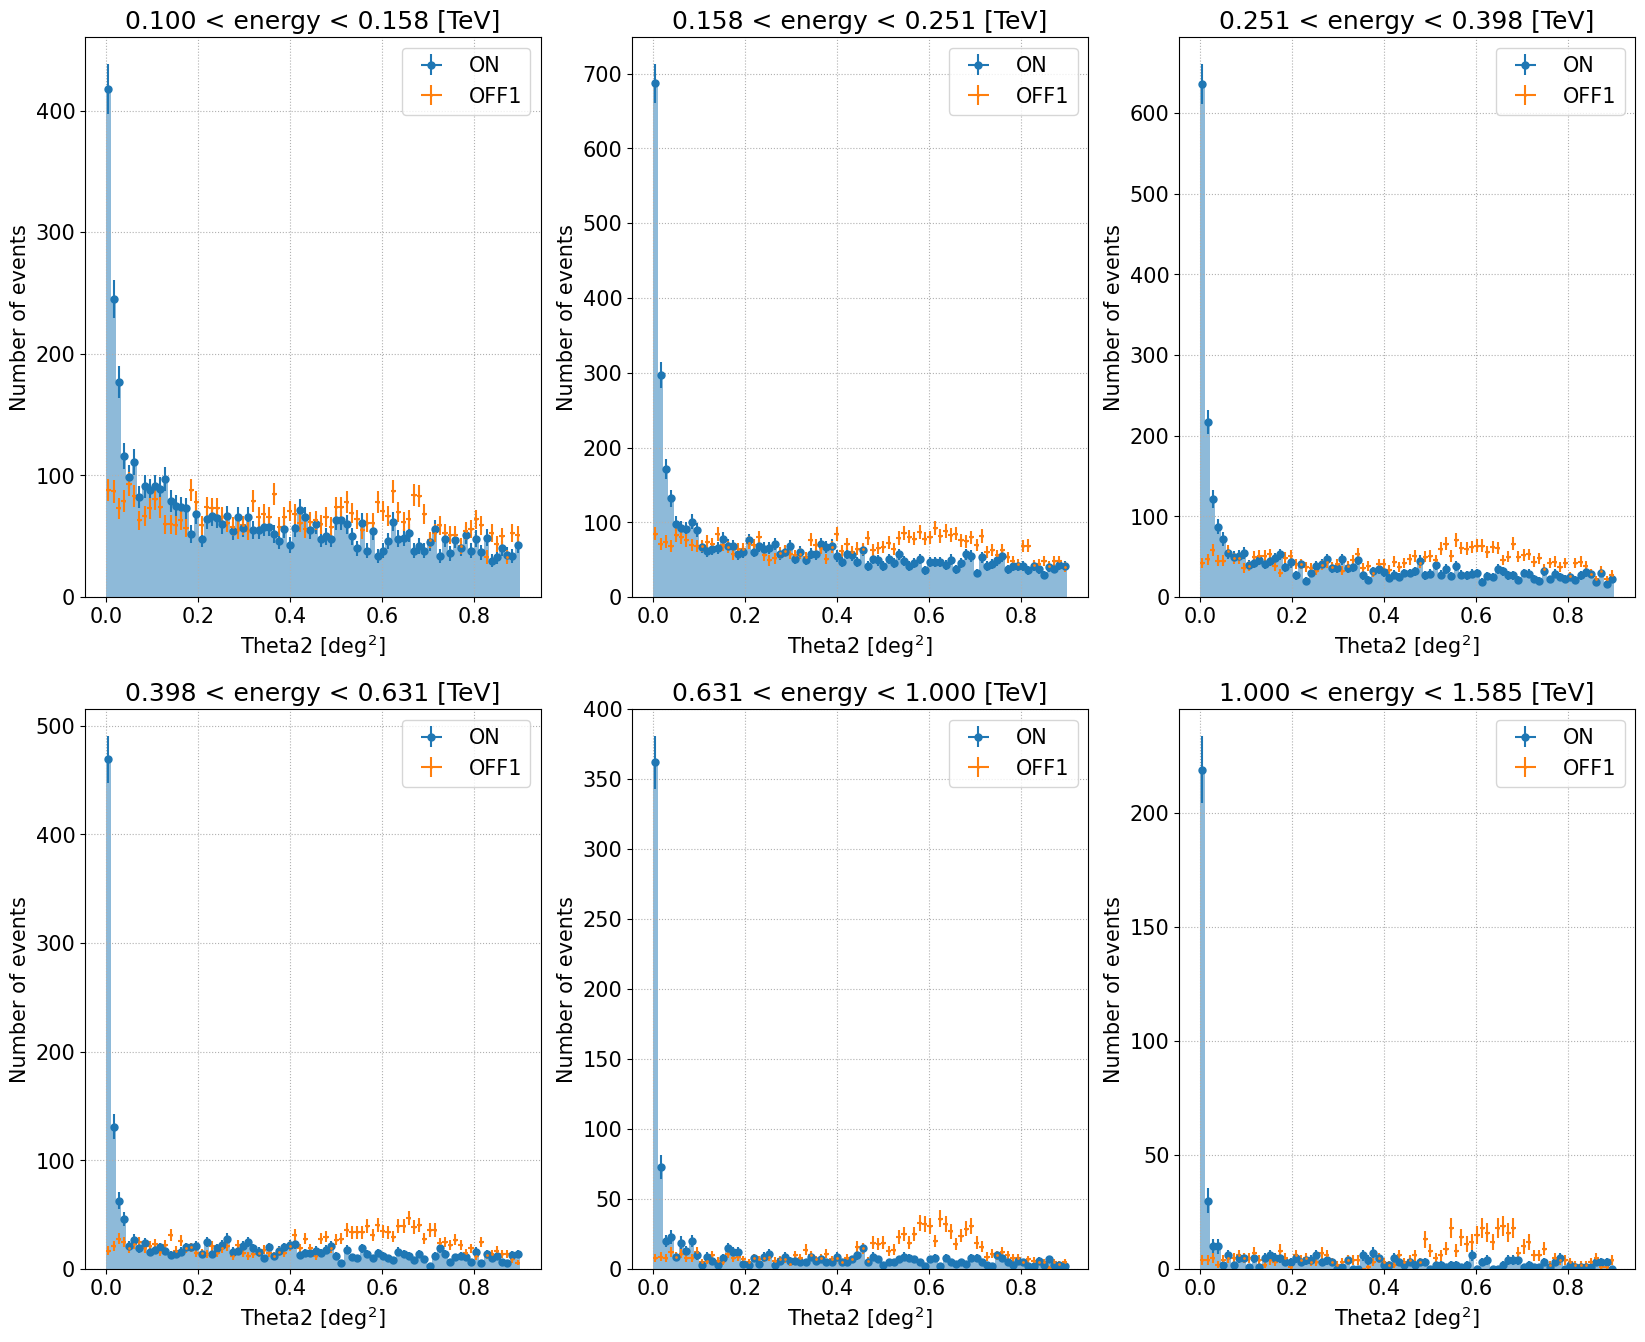

In [21]:
# ================
# === Settings ===
# ================

energy_bins = np.logspace(-1, 1, 11)[:-4]

energy_bins_center = (energy_bins[:-1] + energy_bins[1:]) / 2

energy_bins_width = [
    energy_bins[1:] - energy_bins_center,
    energy_bins_center - energy_bins[:-1],
]
# ============
# === Main ===
# ============

n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lo:.3f} < energy < {eng_hi:.3f} [TeV]")
    plt.xlabel("Theta2 [deg$^2$]")
    plt.ylabel("Number of events")
    plt.grid()

    # Apply the energy cut
    df_events = event_list.query(
        f"(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})"
    ).copy()

    if len(df_events) > 0:

        # Plot the theta2 distribution from the ON coordinate
        hist_on = plt.hist(
            df_events["theta2_on"],
            bins=theta2_bins,
            histtype="bar",
            linewidth=2,
            alpha=0.5,
        )[0]

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_on,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_on),
            fmt="o",
            markersize=5,
            label="ON",
            color=colors[0],
        )

        # Plot the theta2 distribution from the OFF1 coordinate
        hist_off, _ = np.histogram(df_events["theta2_off1"], bins=theta2_bins)

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_off,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_off),
            fmt="o",
            markersize=1,
            label=f"OFF1",
        )

        plt.legend(loc="upper right")

### Angular resolution

Finally, let's check the dependency of the angular resolution with the energy of the incoming photons.

In [22]:
#get event theta value
theta2vec= event_list["theta2_on"]
thetavec=u.Quantity(np.sqrt(theta2vec), u.deg)
#add theta value to dataframe and get a QTable from it
event_list['theta']=thetavec
event_list_table=QTable.from_pandas(event_list)
event_list_table[:5]
#Apply global theta cut to events
mask=event_list_table['theta'].value<np.repeat(np.sqrt(0.04),(len(event_list_table)))
event_list_table=event_list_table[mask]
event_list_table['reco_energy']=u.Quantity(event_list_table['reco_energy'],u.TeV)
#angular resolution
angres_table_Crab = angular_resolution(event_list_table, u.Quantity(energy_bins,u.TeV), energy_type="reco"
)

angres_Crab = angres_table_Crab["angular_resolution"].value
print(f"Angular resolution:\n{angres_Crab} deg")
print(f"Energy bin center:\n{energy_bins_center} TeV")

Angular resolution:
[0.14311825 0.1281979  0.11691379 0.10712637 0.08867532 0.07721625] deg
Energy bin center:
[0.12924466 0.20483898 0.32464791 0.51453226 0.81547867 1.2924466 ] TeV


<ErrorbarContainer object of 3 artists>

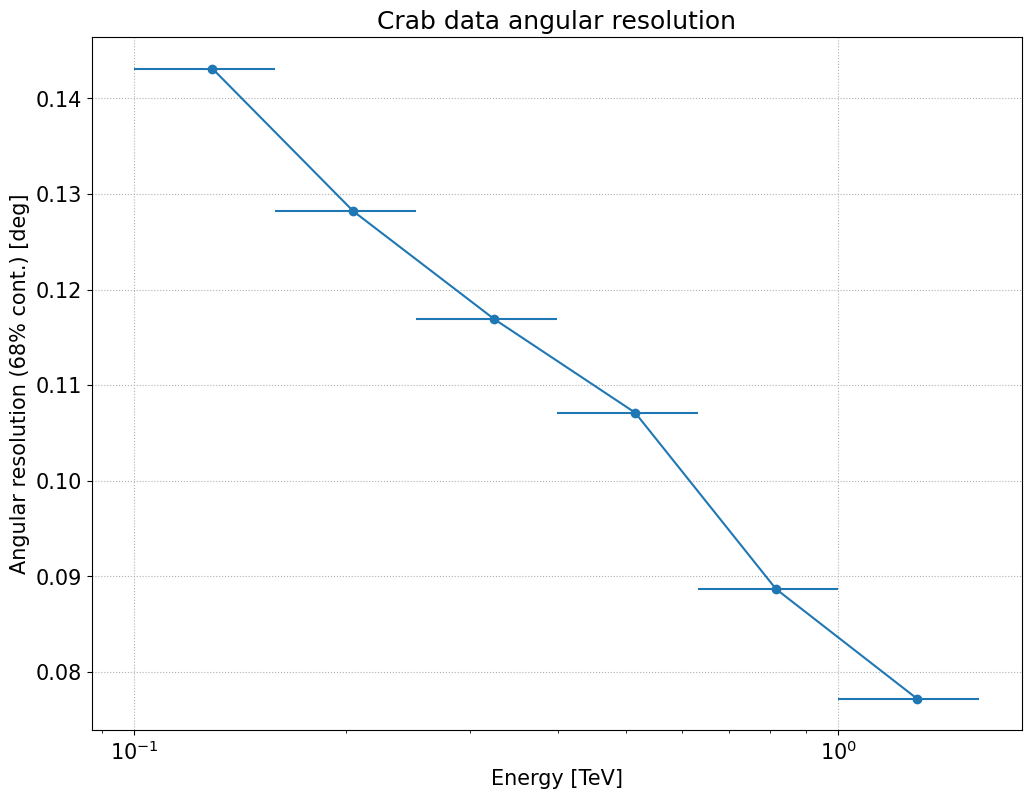

In [23]:
plt.figure()

plt.title(f"Crab data angular resolution")
plt.ylabel("Angular resolution (68% cont.) [deg]")
plt.xlabel("Energy [TeV]")
plt.semilogx()
plt.grid()


plt.errorbar(
    x=energy_bins_center,
    y=angres_Crab,
    xerr=energy_bins_width,
    label="Crab",
    marker="o",
)
